# Logistic regression with 2nd order

*  In this Lab, we will compare a simple GD with a 2nd order method.
*  Feel free to reuse some of your previous codes to fill the missing parts
*  We will consider a logistric regression problem

$$f(x) = \frac1n \sum_{i=1}^n \log(1+\exp(-y_ia_i^Tx))+\frac1{2n} \|x\|^2$$

In [1]:
import numpy as np
import torch

np.random.seed(0)
n = 10000
d = 200
A = np.random.randn(n,d)
xo = np.random.randn(d)
y = np.ones(n)
y[np.dot(A,xo)<0]=-1


A = torch.tensor(A, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
xo = torch.tensor(xo, dtype=torch.float32)

# Task 1
Using pytorch, implement gradient descent with a line-search

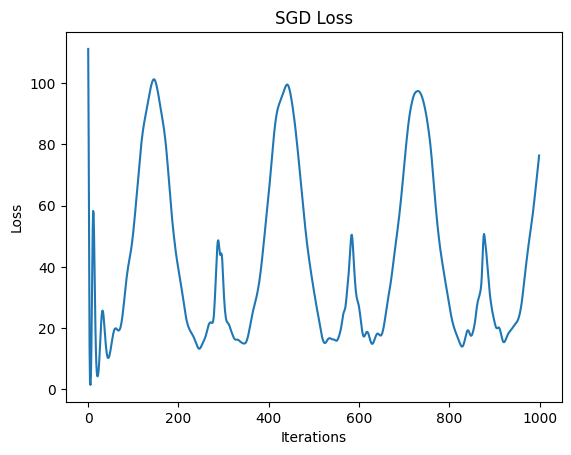

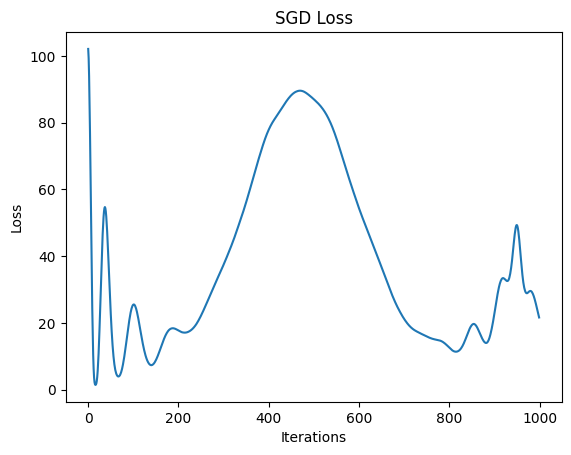

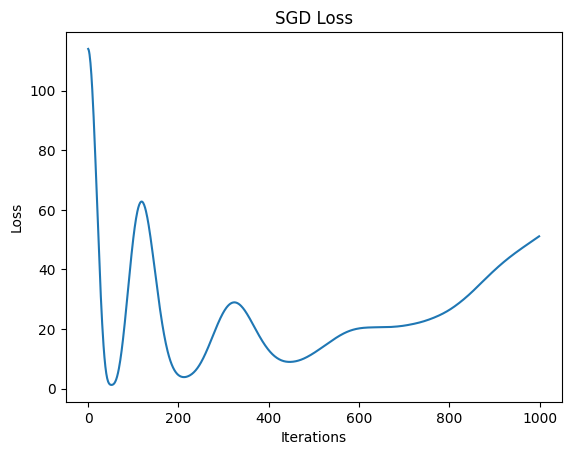

In [2]:
import torch
import copy
import matplotlib.pyplot as plt

def log_reg(A, y, x):
    return torch.log(1 + torch.exp(-y * torch.matmul(A, x))) + (1 / (2 * n)) * torch.norm(x)**2


## Using pytorch, implement gradient descent with a line-search
x = copy.deepcopy(xo)
for lr in [0.1, 0.01, 0.001]:
    sgd_loss = []
    x = torch.randn(d, requires_grad=True)
    for i in range(1000):
        x.requires_grad = True
        yhat = log_reg(A, y, x)
        loss = torch.mean((yhat - y)**2)
        loss.backward()
        sgd_loss.append(loss.item())
        with torch.no_grad():
            x -= lr * x.grad
        if loss.item() < 1e-5:
            break

    plt.plot(sgd_loss)
    plt.title('SGD Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

`lr` = 0.1 seems to be best

# Task 2

Implement BFGS method where you will store the full matricies $H_k$. Do not forget to use a line-seach, but note that step-size 1 should be a good choice since the 2nd iteration. Feel free to test this.

In [3]:
# Re-import necessary libraries after code execution state reset
import torch
import numpy as np

# Re-define the logistic regression function and its gradient for BFGS
def f(x, A, y, n):
    return torch.mean(torch.log(1 + torch.exp(-y * torch.matmul(A, x)))) + (1 / (2 * n)) * torch.norm(x)**2

def grad_f(x, A, y, n):
    # Ensure x is a leaf tensor by detaching it from the computation graph
    x_detached = x.detach().requires_grad_(True)
    value = f(x_detached, A, y, n)
    value.backward()
    return x_detached.grad


In [4]:
def bfgs_algorithm_verbose(A, y, initial_guess, max_iter=100, tol=1e-5):

    # Initializing variables
    loss_history = []
    xk = initial_guess.detach().clone()
    Bk = torch.eye(A.shape[1], dtype=torch.float32)  # Initial Hessian approximation (B0)
    k = 0

    # Main loop of BFGS
    while k < max_iter:
        gk = grad_f(xk, A, y, A.shape[0])  # Gradient at the current point
        dk = -torch.matmul(torch.inverse(Bk), gk)  # Descent direction
        alpha_k = 1  # Step size (could be replaced with a line search)
        sk = alpha_k * dk  # Step calculation
        xk1 = xk + sk  # Update design

        # Calculate and print the loss
        loss = f(xk1, A, y, A.shape[0]).item()
        loss_history.append(loss)

        # Check for convergence
        if torch.norm(xk1 - xk) < tol or torch.norm(grad_f(xk1, A, y, A.shape[0])) < tol:
            print(f'Converged at iteration {k}')
            break

        # Obtain the variation in the gradient
        yk = grad_f(xk1, A, y, A.shape[0]) - gk

        # Update the Hessian approximation
        Bs = torch.matmul(Bk, sk)
        Bk1 = Bk + (torch.outer(yk, yk) / yk.dot(sk)) - (torch.outer(Bs, Bs) / sk.dot(Bs))

        # Update variables for next iteration
        xk = xk1.detach().clone()  # Ensure xk is a detached clone for the next iteration
        Bk = Bk1
        k += 1

    return xk, loss_history

# Initialize parameters and data
n = 10000
d = 200
np.random.seed(0)
torch.manual_seed(0)

A = np.random.randn(n, d)
xo = np.random.randn(d)
y = np.ones(n)
y[np.dot(A, xo) < 0] = -1

A = torch.tensor(A, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
xo = torch.tensor(xo, dtype=torch.float32)

optimal_x_verbose, loss_history_bfgs = bfgs_algorithm_verbose(A, y, xo)

Converged at iteration 67


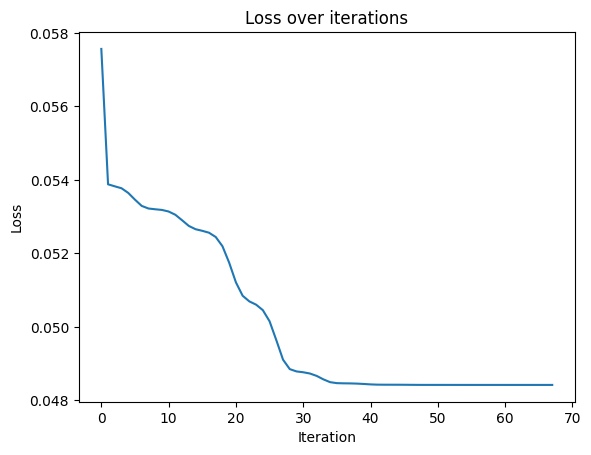

In [5]:
plt.plot(loss_history_bfgs)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

# Task 3

Let's now swich to the limited memory L-BFGS. Implement the two-loop recursion to avoid storing the inverse-Hessian approximation.

*  At beginning, at initial iteration $x_0$ set the initial memory to $(s_0, y_0) = (\nabla f(x_0), \nabla^2 f(x_0) \nabla f(x_0)$.
*  You can also experiment by changing the $y_k = \nabla f(x_{k}) - \nabla f(x_{k-1})$ to $$y_k = \nabla^2 f(x_{k}) (x_k - x_{k-1})$$ which can be computed by Hessian-vector product in pytorch

In [6]:
import torch
import numpy as np

def f(x, A, y, n):
    return torch.mean(torch.log(1 + torch.exp(-y * torch.matmul(A, x)))) + (1 / (2 * n)) * torch.norm(x)**2

def grad_f(x, A, y, n):
    x_detached = x.detach().requires_grad_(True)
    value = f(x_detached, A, y, n)
    value.backward()
    return x_detached.grad

# Define a function to compute the Hessian-vector product
def hessian_vector_product(f, x, v):
    # First compute the gradient
    grad = torch.autograd.grad(f(x), x, create_graph=True)[0]
    # Then compute the dot product with v, making sure v is not a gradient-tracking tensor
    v_detached = v.detach()
    return torch.autograd.grad(grad, x, grad_outputs=v_detached, only_inputs=True, retain_graph=True)[0]

def l_bfgs_with_loss_history(A, y, initial_guess, m=10, max_iter=100, tol=1e-5):
    x = initial_guess.detach().clone().requires_grad_(True)
    gfk = grad_f(x, A, y, A.shape[0]).detach()  # Initial gradient
    loss_history = [f(x, A, y, A.shape[0]).item()]  # Initial loss

    # Initialize memory
    s_mem = [gfk]  # s0 is the negative of the gradient
    y_mem = [hessian_vector_product(lambda x: f(x, A, y, A.shape[0]), x, gfk).detach()]  # Initial y0 using Hessian-vector product

    # Main L-BFGS loop
    for k in range(max_iter):
        q = gfk.clone()
        alphas = []

        # First loop of the two-loop recursion to compute Hk*q
        for si, yi in zip(reversed(s_mem), reversed(y_mem)):
            alpha = si.dot(q) / yi.dot(si)
            alphas.append(alpha)
            q = q - alpha * yi

        # Assuming the initial Hessian approximation H0 is the identity matrix
        r = q

        # Second loop of the two-loop recursion to compute the final product
        for si, yi, alpha in zip(s_mem, y_mem, reversed(alphas)):
            beta = yi.dot(r) / yi.dot(si)
            r = r + si * (alpha - beta)

        # Update the position
        pk = -r
        step_size = 1.0  # In practice, a line search would determine the step size
        x_new = x + step_size * pk
        gfk_new = grad_f(x_new, A, y, A.shape[0]).detach()

        # Record the loss
        loss_history.append(f(x_new, A, y, A.shape[0]).item())

        # Check for convergence
        if torch.norm(gfk_new) < tol:
            print(f'Converged at iteration {k}')
            break

        # Update the memory
        sk = x_new - x
        yk = hessian_vector_product(lambda x: f(x, A, y, A.shape[0]), x_new, sk).detach()  # Update yk using Hessian-vector product

        if len(s_mem) >= m:
            s_mem.pop(0)
            y_mem.pop(0)
        s_mem.append(sk)
        y_mem.append(yk)

        # Move to the new point
        x = x_new.detach().clone().requires_grad_(True)
        gfk = gfk_new

    return x, loss_history


n = 10000
d = 200
np.random.seed(0)
torch.manual_seed(0)

A = np.random.randn(n, d)
xo = np.random.randn(d)
y = np.ones(n)
y[np.dot(A, xo) < 0] = -1

A = torch.tensor(A, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
xo = torch.tensor(xo, dtype=torch.float32, requires_grad=True)

optimal_x_l_bfgs, loss_history_lbfgs = l_bfgs_with_loss_history(A, y, xo)


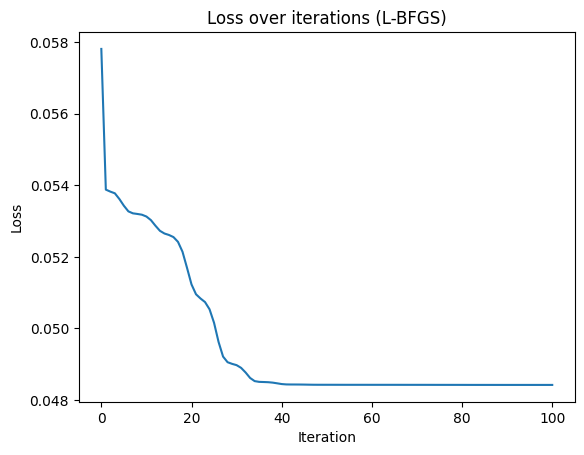

In [7]:
plt.plot(loss_history_lbfgs)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations (L-BFGS)')
plt.show()

# Task 4
*  compare all the methods you developed

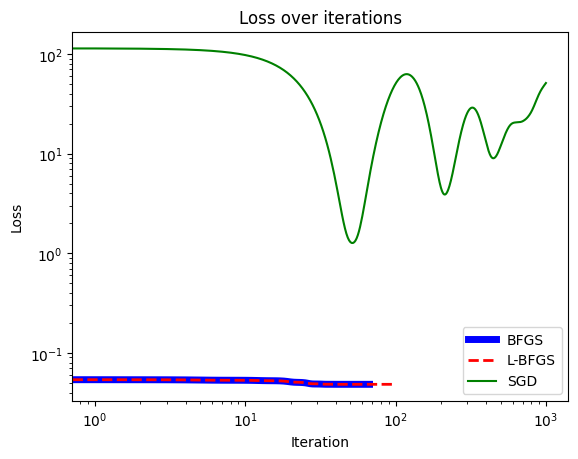

In [18]:
## plto the loss history for all three methods
plt.loglog(loss_history_bfgs, label='BFGS', linewidth=5, color='blue')
plt.loglog(loss_history_lbfgs, label='L-BFGS', linestyle='--', color='red', linewidth=2)
plt.loglog(sgd_loss, label='SGD', color='green')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.legend()
plt.show()
